### Analysis of Indel Recombitron data 

#### Sequence based analysis (not relying on CRISPResso)

In [3]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil
from functions_ import *

In [4]:
### define the necessary variables

base_dir = os.getcwd() 
amplicon = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"

amplicon_DNA = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'

amplicon_DNA_corrected = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'## since all the sequenced reads have an "A" instead of "G" at the 413th position of the LOV2 gene, we correct the sequence here

amplicon_start = "CGCCGCATGGAAGCGATTAACGAAAGCAGCGGT"
amplicon_end = "GGGAGCCTGCATCCGCCGATGGATAACCGCGTG"
LOV_gene_end = "ACATTGATGAAGCGGCCAAA"

LOV_gene = "TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAA"

LOV_gene_corrected = 'TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAA' ## since all the sequenced reads have an "A" instead of "G" at the 413th position, we correct the sequence here

LOV = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"

gene_len = len(LOV)*3
catch_left = 'AAGCAGCGGT'
catch_right = 'GGGAGCCTGC'
offset_left = 3
offset_right= 5

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [7]:
### read sequences from fastq files

a_seqs, b_seqs = read_sequences("RL1", catch_left="", catch_right="")

target_R1 = "TTAGCCACA" ## seq right after linker 1
target_R2 = "GCGGCCAAA" ## seq right before linker 2

print("a_seq with target:", sum(target_R1 in seq for seq in a_seqs))
print("b_seq with target:", sum(dna_rev_comp(target_R2) in seq for seq in b_seqs))

b_seqs_comp = [dna_rev_comp(seq) for seq in b_seqs]

total reads 48196
a_seq with target: 29251
b_seq with target: 23129


In [8]:
b_seqs

['',
 '',
 '',
 '',
 '',
 'C',
 'CCCCGCACGCGGTTATCCATCGGCGGATGCAGGCTTTCGTTAATCGCTTCCATGCGGCGGGGAGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTCTTGTACTGTGTAGATCTCGG',
 'CCCCGCACGCGGTTATCCATCGCTTCCATGCGGCGGGGAGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTCTTGTACTGTGTAGA',
 'CCCCGCACGCGGTTATCCATCGGCGGATGCAGGCTCCCTTTGGCCGCTTCATCAATGTTTTCAGCAGTCTTTTTAATTAAGAATGTGATTACGAAATTCTTTTCAATGCGTTCCAGCGTTGT',
 'CCCCGCACGCGGTTATCCATCGGCGGATGCAGATATTTGGCCGCCTCATCAATGTTTTCAGCAGTCTTTTTAATTAACATTACACCTTCACGCTCCGCAGC',
 'CCCCGCACGCGGTTATCCATCGGCGGATGCAGGCTTTCGTTAATCGCTTCCATGCGGCGGGGAGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTCTTGTACTGTGTA',
 'CCCCGCACGCGGTTATCCACGGCGGATG',
 'CCCCGCACGCGGTTATCCATCGGCGGATGCAGGCTCCCTTTGGCCGCTTCATCAATGTTTTCAGCAGTCTTTTTAATTAACATTACACCTTCACGCTCCGCAGCATCGCGAACATGCTCGGTACCATCAAGCTGAACGCCAATGAAATACTGGACATCGCCCTTCTGGTCACGCATAGGCTGCAAGTGAAATAAATTCCAG',
 'CCCCGCACGCGGTTATCCATCGGCGGATGCAGGCTTTCGTTAATCGCTTCCATGCGGCGGGGAGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTCTTGTACTGTGTAGA',
 'CCCCGCACGCGGTTATCCATCGGCGGATGCAGGCTCCCTTTGGCCGCTTCATCAA

In [8]:
insertions = [#"X",
   #"GG",
   # "PP",
    #"GXG"
   "GGSG",
   "GSGG",
   "GPPG",
   "GSGSG",
   "GPPPG",
   "GSGGSG",
   "GPPPPG"] + ["G"+x+"G" for x in ecoli_pref.keys()] # + "GXG" AAs ## !!! "X" insertions are not included here, also "PP" and "GG" are not included here


insertion_codons = {insertion : "".join([ecoli_pref[Aa] for Aa in insertion]) for insertion in insertions }
subst = {Aa: "".join([ecoli_pref[a] for a in Aa]) for Aa in ["GG", "PP"]}
deletions = {"del1": "-"*9, # deletion of SG + deletion of the AA in front = total of 9 nucleotides
             "del2": "-"*12,
             "del3": "-"*15,}

In [9]:
intended_changes = list(insertion_codons.values()) + list(subst.values())+ list(ecoli_pref.values())

In [31]:
adaptor_left = "CCC" ## for a_seq
seq_before_linker = "TTAACGAAAGC"
seq_after_linker = "TTAGCCACAA"
total_seq = "cgccgCATGGAAGCGATTAACGAAAGC".upper()#"GCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCT" # sequence from primer until linker
linker_seq = "AGCGGT" 
reads = a_seqs

linker_vars, linker_vars_perc, linker_AA_perc = get_linker_variants(reads=reads, seq_before_linker=seq_before_linker, seq_after_linker=seq_after_linker, total_seq=total_seq,  wt_linker=linker_seq, include_changes_after_linker = True, include_deletions = True, intended_changes = intended_changes, combine_other = False, adaptor_left=adaptor_left, filter_treshold = 0.05, rev_reads=False)

total reads 48196
reads with target sequence 29202


In [63]:
adaptor_left = "CCCC" # for b_seq
seq_before_linker = "GCGGCCAAA"
seq_after_linker ="CTGCATCC"
total_seq = "CTGCATCCGCCGATGGATAACCGcgtgc".upper()
linker_seq = "GGGAGC" 
reads = b_seqs_comp
linker_vars, linker_vars_perc, linker_AA_perc = get_linker_variants(reads=reads, seq_before_linker=seq_before_linker, seq_after_linker=seq_after_linker, total_seq=total_seq,  wt_linker=linker_seq, include_changes_after_linker = True, include_deletions = True, intended_changes = intended_changes, combine_other = False, adaptor_left=adaptor_left, filter_treshold = 0.05, rev_reads=True)

total reads 48196
reads with target sequence 36820


In [64]:
linker_vars_perc

{'wt': 71.95413282369803,
 'GTG': 0.9164748295183078,
 'CCG': 0.8513225904530252,
 'TGG': 0.8382921426399688,
 'CTG': 0.8339486600356166,
 'CGT': 0.7557659731572774,
 'TTT': 0.7340485601355167,
 'GGCGGCAGCGGC': 0.7079876645094036,
 'ATG': 0.6558658732571776,
 'ACC': 0.6515223906528254,
 'CAG': 0.6428354254441211,
 'GCG': 0.6341484602354168,
 'TGC': 0.6254614950267124,
 'TAT': 0.5994005994005994,
 'GGCGTGGGC': 0.5994005994005994,
 'GAA': 0.5950571167962472,
 'ATT': 0.5863701515875429,
 'GGCTATGGC': 0.5820266689831907,
 'GAT': 0.5820266689831907,
 'CAT': 0.5733397037744864,
 'GGCCATGGC': 0.5733397037744864,
 'GGCCAGGGC': 0.5689962211701342,
 'GGCCCGGGC': 0.564652738565782,
 'GGCAAAGGC': 0.564652738565782,
 'GGCATGGGC': 0.5472788081483734,
 'GGCGGCGGC': 0.5472788081483734,
 'AGC': 0.5255613951266125,
 'GGCTGGGGC': 0.5212179125222604,
 'GGCAGCGGCGGC': 0.5038439821048517,
 'GGCTGCGGC': 0.49515701689614733,
 'AAC': 0.4908135342917952,
 'GGCCTGGGC': 0.4908135342917952,
 'GGCATTGGC': 0.4908135

In [61]:
linker_vars_perc

{'wt': 72.06995562516315,
 'GTG': 0.9179500565561647,
 'CCG': 0.8526929435308448,
 'TGG': 0.839641520925781,
 'CTG': 0.8352910467240929,
 'CGT': 0.7569825110937093,
 'TTT': 0.7352301400852693,
 'GGCGGCAGCGGC': 0.7091272948751415,
 'ATG': 0.6569216044548856,
 'ACC': 0.6525711302531976,
 'CAG': 0.6438701818498216,
 'GCG': 0.6351692334464457,
 'TGC': 0.6264682850430697,
 'TAT': 0.6003654398329418,
 'GGCGTGGGC': 0.6003654398329418,
 'GAA': 0.5960149656312538,
 'ATT': 0.5873140172278779,
 'GGCTATGGC': 0.5829635430261899,
 'GAT': 0.5829635430261899,
 'CAT': 0.5742625946228139,
 'GGCCATGGC': 0.5742625946228139,
 'GGCCAGGGC': 0.5699121204211258,
 'GGCCCGGGC': 0.5655616462194379,
 'GGCAAAGGC': 0.5655616462194379,
 'GGCATGGGC': 0.548159749412686,
 'GGCGGCGGC': 0.548159749412686,
 'AGC': 0.526407378404246,
 'GGCTGGGGC': 0.522056904202558,
 'GGCAGCGGCGGC': 0.5046550073958062,
 'GGCTGCGGC': 0.4959540589924301,
 'AAC': 0.49160358479074223,
 'GGCCTGGGC': 0.49160358479074223,
 'GGCATTGGC': 0.491603584

In [41]:
## exclude wt 
linker_vars_perc = {seq: count for seq,count in linker_vars_perc.items() if seq != "wt"}
for change in intended_changes + ["del-9", "del-12", "del-15"]:
    print(change in linker_vars_perc.keys()) if change not in linker_vars_perc.keys() else None
    if change not in linker_vars_perc.keys():
        linker_vars_perc[change] = 0
        
linker_AA_perc  = {seq: count for seq,count in linker_AA_perc.items() if seq != "wt"}
for change in intended_changes + ["del-9", "del-12", "del-15"]:
    change = translate_dna2aa(change) if change[0] in ["A","C","G","T"] else change
    print(change in linker_AA_perc.keys()) if change not in linker_AA_perc.keys() else None
    if change not in linker_AA_perc.keys():
        linker_AA_perc[change] = 0

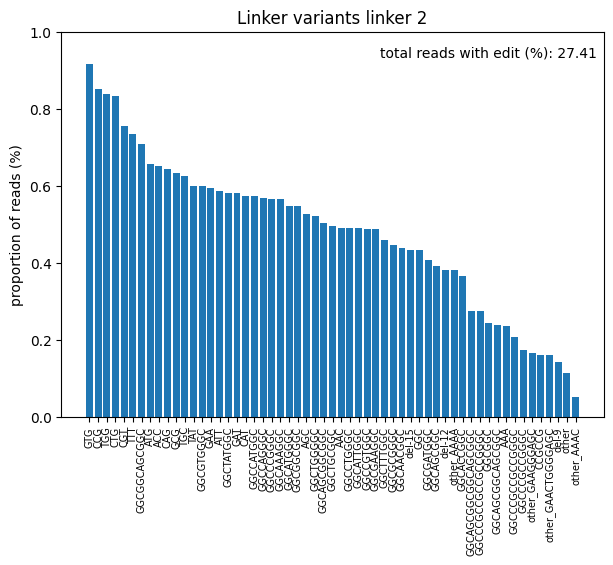

In [44]:
plt.figure(figsize=(7,5))
plt.bar(list(linker_vars_perc.keys()), list(linker_vars_perc.values()))
plt.title("Linker variants linker 2")
plt.xticks(rotation=90, fontsize = 7)
plt.ylabel("proportion of reads (%)")  
plt.ylim(0,1.0)
## add text at top right corner
plt.text(0.58, 0.83, "total reads with edit (%): "+str(round(sum(linker_vars_perc.values()),2)), fontsize = 10, transform=plt.gcf().transFigure)
plt.savefig("output/RL1/linker_R2_indel_Nt_freq.pdf", bbox_inches = "tight")    
plt.show()

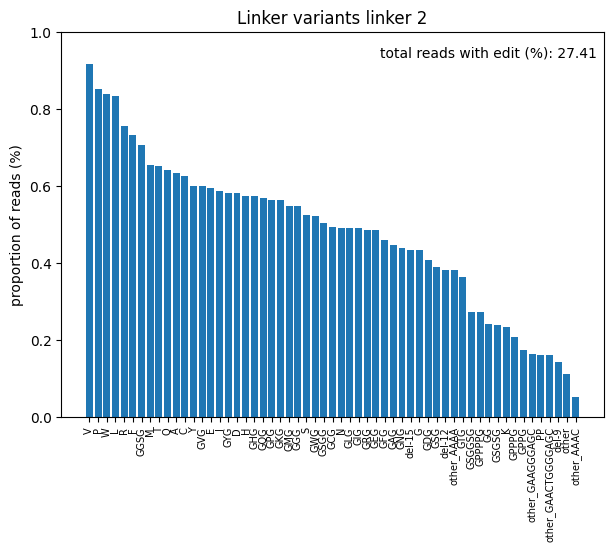

In [43]:
plt.figure(figsize=(7,5))
plt.bar(list(linker_AA_perc.keys()), list(linker_AA_perc.values()))
plt.title("Linker variants linker 2")
plt.xticks(rotation=90, fontsize = 7)
plt.ylabel("proportion of reads (%)")  
plt.ylim(0,1.0)
## add text at top right corner
plt.text(0.58, 0.83, "total reads with edit (%): "+str(round(sum(linker_vars_perc.values()),2)), fontsize = 10, transform=plt.gcf().transFigure)
plt.savefig("output/RL1/linker_R2_indel_AA_freq.pdf", bbox_inches = "tight")    
plt.show()

In [35]:
for key in linker_vars_perc.keys():
    print(key, linker_vars[key])

other_AGCGGC 225
CAG 125
AGC 124
TGG 117
CCG 117
TGC 116
GTG 116
CTG 107
CGT 104
GGC 99
ACC 99
GCG 96
AAC 92
TTT 87
ATG 84
ATT 81
GGCATGGGC 80
AAA 78
GGCGTGGGC 77
GAA 75
CAT 75
GGCTGGGGC 75
GGCGATGGC 75
GGCTGCGGC 74
GGCGAAGGC 70
TAT 70
GGCTATGGC 70
GGCGGCGGC 68
GGCAGCGGC 67
GGCAAAGGC 66
GAT 66
GGCCATGGC 61
GGCACCGGC 58
CCGCCG 56
GGCGGC 55
GGCGCGGGC 53
GGCATTGGC 52
other 51
GGCTTTGGC 48
GGCCTGGGC 48
GGCAACGGC 47
GGCCCGGGC 46
GGCCAGGGC 45
del-12 44
GGCCGTGGC 43
GGCAGCGGCGGC 41
GGCCCGCCGCCGGGC 41
del-15 40
GGCCCGCCGCCGCCGGGC 34
GGCAGCGGCAGCGGC 26
GGCGGCAGCGGC 24
del-9 21
GGCAGCGGCGGCAGCGGC 20
GGCCCGCCGGGC 15
